# NLP - Sentiment Analysis from Tweets

In [297]:
import csv                               # csv reader
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support # to report on precision and recall
import numpy as np

In [298]:
def load_data(path):
    """Load data from a tab-separated file and append it to raw_data."""
    with open(path) as f:
        reader = csv.reader(f, delimiter='\t')
        for line in reader:
            if line[0] == "Id":  # skip header
                continue
            (label, text) = parse_data_line(line)
            raw_data.append((text, label))

def split_and_preprocess_data(percentage):
    """Split the data between train_data and test_data according to the percentage
    and performs the preprocessing."""
    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples))
    for (text, label) in raw_data[:num_training_samples]:
        train_data.append((to_feature_vector(pre_process(text)),label))
    for (text, label) in raw_data[num_training_samples:]:
        test_data.append((to_feature_vector(pre_process(text)),label))

# Input and preprocessing

In [299]:
def parse_data_line(data_line):
    label= data_line[1]
    text = data_line[2]
    return (label, text)

In [300]:
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from textblob import TextBlob



# Input: a string of one statement
def pre_process(text):
    # Tokenization
    words = word_tokenize(text)

    # Lowercasing
    words = [word.lower() for word in words]

    # Removing special characters
    words = [re.sub(r'[^A-Za-z0-9]', '', word) for word in words]

    # Handling negations
    negations = set(["not", "no", "never"])
    for i in range(len(words)):
        if words[i] in negations and i < len(words) - 1:
            words[i + 1] = "not_" + words[i + 1]

    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word.isalnum() and word.lower() not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    # Stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]

    # Expand contractions
    contractions = {"don't": "do not", "can't": "cannot", "won't": "will not"}
    words = [contractions.get(word, word) for word in words]

    # Replace numbers with a placeholder
    words = ['number' if word.isdigit() else word for word in words]

    # Sentiment analysis
    sentiment = TextBlob(text).sentiment
    words.append('positive' if sentiment.polarity > 0 else 'negative' if sentiment.polarity < 0 else 'neutral')


    return words

# Feature Extraction

In [301]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import ngrams

global_feature_dict = {}  # A global dictionary of features

def to_feature_vector(tokens):
    # Create a dictionary to store features
    feature_vector = {}
    
    # Iterate through each token in the list of tokens
    for token in tokens:
        if token not in global_feature_dict:
            global_feature_dict[token] = 0
        global_feature_dict[token] += 1

        if token not in feature_vector:
            feature_vector[token] = 0
        feature_vector[token] += 1

    """#TF-IDF
    text = " ".join(tokens)
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform([text])
    feature_names = vectorizer.get_feature_names()
    feature_vector.update({feature_names[i]: tfidf_matrix[0, i] for i in range(len(feature_names))})"""

    #N-grams (bigrams and trigrams)
    bigrams = list(ngrams(tokens, 2))
    trigrams = list(ngrams(tokens, 3))
    feature_vector.update({"bigram_" + "_".join(bigram): 1 for bigram in bigrams})
    feature_vector.update({"trigram_" + "_".join(trigram): 1 for trigram in trigrams})

    #Document Length
    feature_vector["document_length"] = len(tokens)

    
    return feature_vector

In [302]:
# TRAINING AND VALIDATING OUR CLASSIFIER

def train_classifier(data, C=1.0, class_weight=None):
    print("Training Classifier...")
    pipeline = Pipeline([('svc', LinearSVC(C=C, class_weight=class_weight))])
    return SklearnClassifier(pipeline).train(data)

# Cross-validation 

In [303]:
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd


def cross_validate(dataset, folds,test_size=0.2):
    cv_results = []
    fold_size = int(len(dataset) / folds) + 1

    for i in range(0, len(dataset), int(fold_size)):
        # Train classifier on current fold (training set)
        training_data = dataset[i:i + fold_size]

        # Evaluate classifier on remaining folds (test set)
        testing_data = []
        for j in range(0, folds):
            if j == i:
                continue
            testing_data.extend(dataset[j * fold_size:(j + 1) * fold_size])

        # Train and evaluate the classifier
        classifier = train_classifier(training_data,C=10,class_weight='balanced')

        testing_data_dicts = []

        for feature_vector, label in testing_data:
            testing_data_dicts.append({feature: value for feature, value in feature_vector.items()})
            
        predicted_labels = predict_labels(testing_data_dicts, classifier)
        true_labels = [label for _, label in testing_data]

        # Calculate performance metrics
        precision, recall, fscore, _ = precision_recall_fscore_support(true_labels, predicted_labels)
        accuracy = accuracy_score(true_labels, predicted_labels)
        cv_results.append((precision, recall, fscore, accuracy))

        # Calculate average performance across folds
        avg_precision = sum(precision) / folds
        avg_recall = sum(recall) / folds
        avg_fscore = sum(fscore) / folds
        avg_accuracy = accuracy

        print("Average Precision: {:.2f}".format(avg_precision))
        print("Average Recall: {:.2f}".format(avg_recall))
        print("Average F-Score: {:.2f}".format(avg_fscore))
        print("Average Accuracy: {:.2f}".format(avg_accuracy))

     # Create a Pandas DataFrame
    results_df = pd.DataFrame(cv_results)

     # Rename the columns for better readability
    results_df.columns = ['Precision', 'Recall', 'F-Score','Accuracy']

    # Print the detailed results
    print("\nCross-Validation Results:")

    return results_df

In [304]:
# PREDICTING LABELS GIVEN A CLASSIFIER

def predict_labels(samples, classifier):
    """Assuming preprocessed samples, return their predicted labels from the classifier model."""
    return classifier.classify_many(samples)

def predict_label_from_raw(sample, classifier):
    """Assuming raw text, return its predicted label from the classifier model."""
    return classifier.classify(to_feature_vector(preProcess(reviewSample)))

In [305]:
# MAIN

# loading reviews
# initialize global lists that will be appended to by the methods below
raw_data = []          # the filtered data from the dataset file
train_data = []        # the pre-processed training data as a percentage of the total dataset
test_data = []         # the pre-processed test data as a percentage of the total dataset


# references to the data files
data_file_path = 'sentiment-dataset.tsv'

# Do the actual stuff (i.e. call the functions we've made)
# We parse the dataset and put it in a raw data list
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing the dataset...",sep='\n')

load_data(data_file_path) 

# We split the raw dataset into a set of training data and a set of test data (80/20)
# You do the cross validation on the 80% (training data)
# We print the number of training samples and the number of features before the split
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing training and test data...",sep='\n')

split_and_preprocess_data(0.8)

# We print the number of training samples and the number of features after the split
print("After split, %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Training Samples: ", len(train_data), "Features: ", len(global_feature_dict), sep='\n')


Now 0 rawData, 0 trainData, 0 testData
Preparing the dataset...
Now 33540 rawData, 0 trainData, 0 testData
Preparing training and test data...
After split, 33540 rawData, 26832 trainData, 6708 testData
Training Samples: 
26832
Features: 
50594


In [306]:
cross_validate(train_data, 10)  # will work and output overall performance of p, r, f-score when cv implemented

Training Classifier...


/Users/sako/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Average Precision: 0.16
Average Recall: 0.15
Average F-Score: 0.15
Average Accuracy: 0.80
Training Classifier...


/Users/sako/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Average Precision: 0.16
Average Recall: 0.14
Average F-Score: 0.14
Average Accuracy: 0.77
Training Classifier...
Average Precision: 0.16
Average Recall: 0.16
Average F-Score: 0.16
Average Accuracy: 0.82
Training Classifier...
Average Precision: 0.16
Average Recall: 0.16
Average F-Score: 0.16
Average Accuracy: 0.83
Training Classifier...
Average Precision: 0.16
Average Recall: 0.16
Average F-Score: 0.16
Average Accuracy: 0.83
Training Classifier...
Average Precision: 0.16
Average Recall: 0.16
Average F-Score: 0.16
Average Accuracy: 0.83
Training Classifier...


/Users/sako/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Average Precision: 0.17
Average Recall: 0.16
Average F-Score: 0.16
Average Accuracy: 0.83
Training Classifier...
Average Precision: 0.17
Average Recall: 0.16
Average F-Score: 0.16
Average Accuracy: 0.83
Training Classifier...
Average Precision: 0.17
Average Recall: 0.16
Average F-Score: 0.16
Average Accuracy: 0.83
Training Classifier...


/Users/sako/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Average Precision: 0.17
Average Recall: 0.16
Average F-Score: 0.16
Average Accuracy: 0.84

Cross-Validation Results:


,Precision,Recall,F-Score,Accuracy
0,"[0.7923383878691141, 0.8042274786109713]","[0.5864146485528647, 0.9170439329209973]","[0.6739986422267481, 0.8569385687898468]",0.801143
1,"[0.801195219123506, 0.758802494039978]","[0.43326510826241516, 0.9431306627158242]","[0.562399496609103, 0.8409847310789869]",0.766734
2,"[0.7630568803070839, 0.8506717850287908]","[0.7066681029839491, 0.8839250099720782]","[0.7337807606263983, 0.8669796557120502]",0.822600
3,"[0.7810354857475277, 0.8590776991829796]","[0.7231498438004955, 0.8927574220753319]","[0.7509788566953798, 0.8755938076342702]",0.834079
4,"[0.8073997679515277, 0.8416775884665793]","[0.6746741355165357, 0.9148669439854122]","[0.7350938967136151, 0.8767474879860201]",0.831768
5,"[0.8000499875031242, 0.8469994689325544]","[0.6896477431864699, 0.9088267137728645]","[0.7407578825571304, 0.8768245416311607]",0.832998
6,"[0.8135103167301879, 0.8390989959943818]","[0.6668102983949155, 0.9191406917773093]","[0.7328913094956193, 0.877297944087893]",0.831843
7,"[0.8087326120556414, 0.842458569330816]","[0.6763977162555208, 0.9153797937204399]","[0.736669208658415, 0.8774066690335091]",0.832700
8,"[0.814257161892072, 0.8358772701402184]","[0.6583001184961758, 0.9205652743746082]","[0.7280200142959257, 0.8761796290270094]",0.829830
9,"[0.8128300914594873, 0.8440925061618333]","[0.6797371539373047, 0.9172032594449826]","[0.7403496421447847, 0.879130482276476]",0.835048


# Error Analysis

In [307]:
from sklearn import metrics
import matplotlib.pyplot as plt
# a function to make the confusion matrix readable and pretty
def confusion_matrix_heatmap(y_test, preds, labels):
    """Function to plot a confusion matrix"""
    # pass labels to the confusion matrix function to ensure right order
    # cm = metrics.confusion_matrix(y_test, preds, labels)
    cm = metrics.confusion_matrix(y_test, preds, labels=labels)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!
    plt.show()

In [308]:
def error_analysis(classifier, test_data):
    """Perform error analysis on a simple train-test split."""
    test_samples, true_labels = zip(*test_data)
    predicted_labels = predict_labels(test_samples, classifier)

    # Create a list of tuples 
    errors = [(test_samples[i], true_labels[i], predicted_labels[i]) for i in range(len(test_samples)) if true_labels[i] != predicted_labels[i]]

    # Print false positives and false negatives for the positive label
    with open('error_analysis2.txt', 'w') as f:
        f.write("False Positives (Predicted Positive, Actual Negative):\n")
        for sample, true_label, predicted_label in errors:
            if predicted_label == 'positive' and true_label == 'negative':
                f.write(f"Sample: {sample}, Actual: {true_label}, Predicted: {predicted_label}\n")

        f.write("\nFalse Negatives (Predicted Negative, Actual Positive):\n")
        for sample, true_label, predicted_label in errors:
            if predicted_label == 'negative' and true_label == 'positive':
                f.write(f"Sample: {sample}, Actual: {true_label}, Predicted: {predicted_label}\n")

    print("Error analysis written to error_analysis2.txt")


In [309]:
classifier = train_classifier(train_data)  # train on the entire training set for simplicity
test_samples, true_labels = zip(*test_data)
predicted_labels = predict_labels(test_samples, classifier)

error_analysis(classifier, test_data)


Training Classifier...


/Users/sako/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Error analysis written to error_analysis2.txt


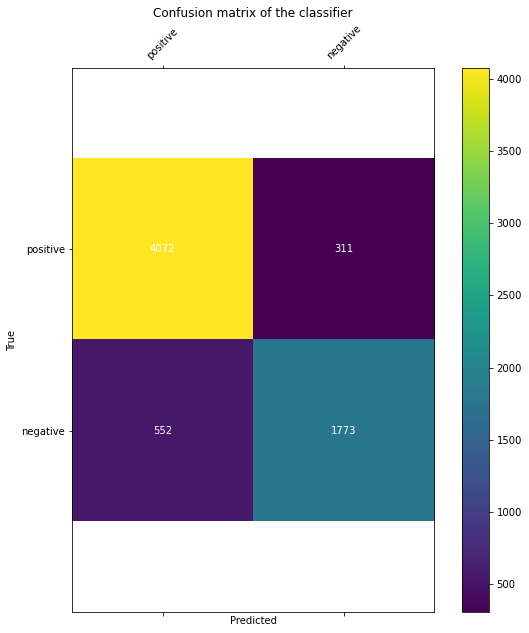

In [310]:
confusion_matrix_heatmap(true_labels, predicted_labels, ['positive', 'negative'])

In [312]:
# Finally, check the accuracy of your classifier by training on all the traning data
# and testing on the test set
# Will only work once all functions are complete
functions_complete = True  # set to True once you're happy with your methods for cross val
if functions_complete:
    print(test_data[0])   # have a look at the first test data instance
    classifier = train_classifier(train_data)  # train the classifier
    test_true = [t[1] for t in test_data]   # get the ground-truth labels from the data
    test_pred = predict_labels([x[0] for x in test_data], classifier)  # classify the test data to get predicted labels
    final_scores = precision_recall_fscore_support(test_true, test_pred, average='weighted') # evaluate
    print("Done training!")
    print("Precision: %f\nRecall: %f\nF Score:%f" % final_scores[:3])

({'tomorrow': 1, 'releas': 1, '58th': 1, 'episod': 1, 'hsonair': 1, 'profil': 1, 'alissadossanto': 1, 'talk': 1, 'storytel': 1, 'beyonc': 1, 'positive': 1, 'bigram_tomorrow_releas': 1, 'bigram_releas_58th': 1, 'bigram_58th_episod': 1, 'bigram_episod_hsonair': 1, 'bigram_hsonair_profil': 1, 'bigram_profil_alissadossanto': 1, 'bigram_alissadossanto_talk': 1, 'bigram_talk_storytel': 1, 'bigram_storytel_beyonc': 1, 'bigram_beyonc_positive': 1, 'trigram_tomorrow_releas_58th': 1, 'trigram_releas_58th_episod': 1, 'trigram_58th_episod_hsonair': 1, 'trigram_episod_hsonair_profil': 1, 'trigram_hsonair_profil_alissadossanto': 1, 'trigram_profil_alissadossanto_talk': 1, 'trigram_alissadossanto_talk_storytel': 1, 'trigram_talk_storytel_beyonc': 1, 'trigram_storytel_beyonc_positive': 1, 'document_length': 11}, 'positive')
Training Classifier...


/Users/sako/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Done training!
Precision: 0.870275
Recall: 0.871348
F Score:0.869553
